In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# use '%matplotlib widget' for interactive plot

import sys
import yaml

from math import pi
from shapely import LineString


from zeroheliumkit import Entity, Structure, Anchor
from zeroheliumkit.src.geometries import Meander, Rectangle, ArcLine
from zeroheliumkit.src.settings import *
from zeroheliumkit.helpers.resonator_calc import *

In [2]:
plot_config = {"gnd": BLUE,
               "open": ORANGE,
               "temp": WHITE,
               "island": YELLOW2,
               "anchors": RED}

In [3]:
def construct_resonator_skeletone(params: dict) -> LineString:
    g_params = params["geometry"]
    d_a = g_params['coupling_length']
    d_w = g_params['distance_from_waveguide']
    d_l = g_params['openend_length']
    d_R = g_params['radius']
    n = g_params['num']
    w = g_params["w"]
    g = g_params["g"]

    cpw_params = CPW_params(params["eps"], w * um, g * um, params["substrate_h"] * um, 0)
    cpw_params.resonator_length(params["frequency"] * GHz, params["type"], 0)
    length = cpw_params.length/um
    
    d_b = (length - (d_l + d_a + d_w + d_R * (3 * pi/2 + 2 * pi * n + 1)))/(2 * n + 1)
    if d_b < 0:
        raise Exception("Incorrect geometry input. Choose different 'bending_radius', 'coupling_length', 'openend_length' or 'num_wiggles'")

    sk = Entity()
    sk.add_line(LineString([(0, 0), (0, d_l)]))
    sk.add_line(ArcLine(-d_R, 0, d_R, 0, 90, 20))
    sk.add_line(LineString([(0, 0), (-d_a, 0)]))
    sk.add_line(ArcLine(0, -d_R, d_R, 90, 180, 20))
    sk.add_line(LineString([(0, 0), (0, -d_w)]))
    sk.add_line(ArcLine(d_R, 0, d_R, 180, 270, 20))
    sk.add_line(LineString([(0, 0), (d_b/2, 0)]), ignore_crossing=True)
    for _ in range(n):
        sk.add_line(Meander(d_b, d_R, direction=-90), ignore_crossing=True)
    sk.add_line(LineString([(0, 0), (d_b/2 + d_R, 0)]))

    return sk.skeletone

In [6]:
resonator_sk

<SKELETONE LINESTRING (0 0, 0 1200, -0.1708 1204.129, -0.6819 1208.2297, -1.53 1212.2743, -2.7091 1216.235, -4.2113 1220.0848, -6.0263 1223.7974, -8.1417 1227.3474, -10.543 1230.7106, -13.2138 1233.8641, -16.1359 1236.7862, -19.2894 1239.457, -22.6526 1241.8583, -26.2026 1243.9737, -29.9152 1245.7887, -33.765 1247.2909, -37.7257 1248.47, -41.7703 1249.3181, -45.871 1249.8292, -50 1250, -350 1250, -354.129 1249.8292, -358.2297 1249.3181, -362.2743 1248.47, -366.235 1247.2909, -370.0848 1245.7887, -373.7974 1243.9737, -377.3474 1241.8583, -380.7106 1239.457, -383.8641 1236.7862, -386.7862 1233.8641, -389.457 1230.7106, -391.8583 1227.3474, -393.9737 1223.7974, -395.7887 1220.0848, -397.2909 1216.235, -398.47 1212.2743, -399.3181 1208.2297, -399.8292 1204.129, -400 1200, -400 1200, -399.8292 1195.871, -399.3181 1191.7703, -398.47 1187.7257, -397.2909 1183.765, -395.7887 1179.9152, -393.9737 1176.2026, -391.8583 1172.6526, -389.457 1169.2894, -386.7862 1166.1359, -383.8641 1163.2138, -380.

-------  ----------  ---------  -------  ---  -------  --------------  -------  -------
f0, GHz  length, mm  width, um  gap, um  eps  eps_eff  impedance, Ohm  L, nH/m  C, pF/m
7.7      3.974       8.0        4.5      11   6.0      50.89           415.79   160.555
-------  ----------  ---------  -------  ---  -------  --------------  -------  -------


<Axes: >

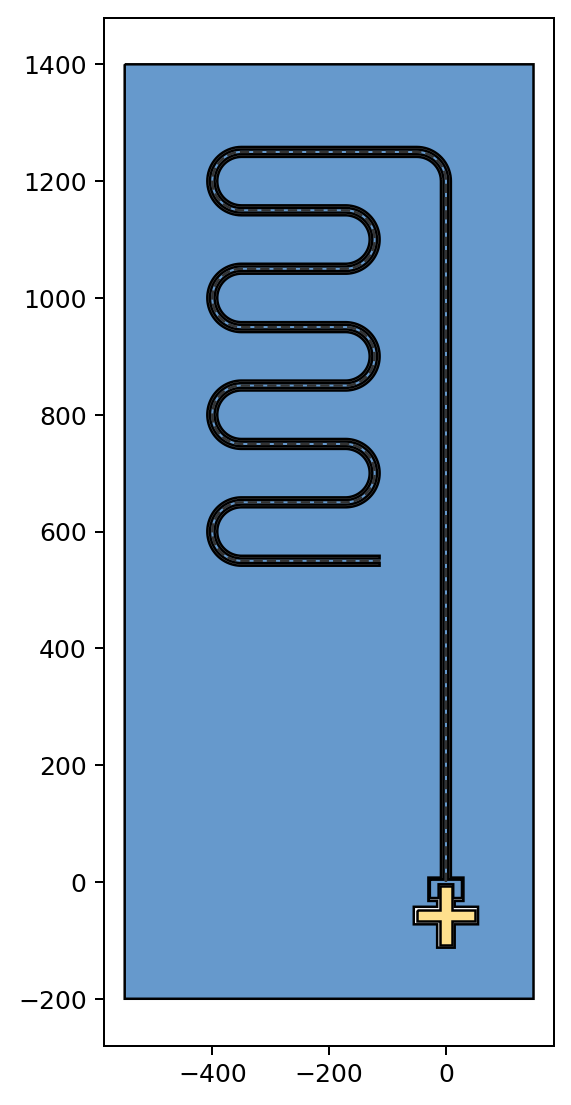

In [7]:
with open('params.yaml', 'r') as file:
    params = yaml.safe_load(file)

gp = params["resonator"]["geometry"]

resonator = Structure()
resonator.skeletone = construct_resonator_skeletone(params["resonator"])
resonator.buffer_line("open", gp["w"]/2 + gp["g"], cap_style="square", join_style="mitre")
resonator.skeletone.add_line(LineString([(0, 0), (10, 0)]))
resonator.buffer_line("temp", gp["w"]/2, cap_style="square", join_style="mitre")
resonator.add_anchor([Anchor((0,0), -90, "end")])

island = Structure()
island.add_layer("island", Rectangle(100, 20, (0,0)))
island.add_polygon("island", Rectangle(20, 100, (0,0)))
island.add_layer("open", island.island.buffer(5, join_style='mitre'))
island.add_anchor([Anchor((0, 57.5), -90, "isl")])

resonator.append(island, anchoring=("end", "isl"))
resonator.add_polygon("open", Rectangle(60, 40, (0, 45 - 57.5)))
resonator.cut_polygon("open", Rectangle(15, 30, (20, 45 - 57.5)))
resonator.cut_polygon("open", Rectangle(15, 30, (-20, 45 - 57.5)))
resonator.cut_polygon("open", Rectangle(55, 8, (0, 0)))
resonator.cut_polygon("open", resonator.temp)
resonator.remove_layer("temp")
resonator.remove_anchor(["isl", "end"])

resonator.add_layer("gnd", Rectangle(700, 1600, (-200, 600)))
resonator.cut_polygon("gnd", resonator.open)
resonator.remove_layer("open")

resonator.quickplot(plot_config)